Exploring image data and masks

In [1]:
!python3 -V

Python 3.9.6


In [2]:
#importing libraries
import tifffile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from patch_extractor import PatchExtractor
import skimage.io as io
import tqdm as tqdm
import warnings
warnings.filterwarnings("ignore")


In [3]:
def read_image(img_path:str,show_image:bool=True)-> np.ndarray:
    """
    Method to read tiff images/Mask
    
    Args:
    img_path:str (Path to the tiff file )

    returns:np.ndarray (Numpy array)
    """
    if not os.path.isfile(img_path):
        raise FileNotFoundError("File not found")
    image = tifffile.imread(img_path)
    if show_image: 
        print(img_path.split("/")[-1])
        print("Image shape",image.shape)
        plt.imshow(image)
        plt.show()
    
    return image

### Test read a image and respective mask

CL_HandE_1234_B004_bottomleft.tiff
Image shape (4536, 4704, 3)


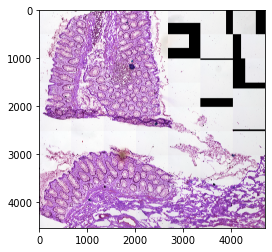

Shaped series: axes do not match shape


CL_HandE_1234_B004_bottomleft.tiff
Image shape (4536, 4704)


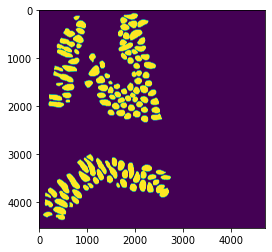

In [4]:
im = read_image("Colonic_crypt_dataset/test/CL_HandE_1234_B004_bottomleft.tiff",show_image=True)
mask =read_image("Colonic_crypt_dataset/test_mask/CL_HandE_1234_B004_bottomleft.tiff",show_image=True)

#### **Path Extraction**

In [5]:
df_train = pd.read_csv("Colonic_crypt_dataset/train.csv")

In [6]:
df_train

,id,predicted
0,CL_HandE_1234_B004_bottomright,12972850 36 12977382 42 12981914 47 12986448 5...
1,CL_HandE_1234_B004_topleft,2023885 36 2028419 40 2032953 44 2037487 47 20...
2,CL_HandE_1234_B004_topright,372094 8 376628 12 381163 14 385698 16 390233 ...
3,HandE_B005_CL_b_RGB_bottomright,2247721 26 2252254 31 2256788 34 2261323 36 22...
4,HandE_B005_CL_b_RGB_topleft,366048 27 370578 43 375111 48 379646 52 384181...
5,HandE_B005_CL_b_RGB_topright,0 0


In [7]:
image_data_dir = "../Colonic_crypt_dataset/train/"
mask_data_dir = "../Colonic_crypt_dataset/train_mask/"
train_patches_directory = "data/"

In [16]:
def extract_train_patches(df_train:pd.DataFrame,image_data_dir:str,mask_data_dir:str,train_patches_directory:str,patch_size:tuple=(512,512),stride_size:tuple=(256,256),overlap_type:str="mirror",include_unannotated_patches = False,save_csv="train_data_with_class.csv")-> None:   

    """
    Method creates a train csv to containing image and mask paths
    
    args:
    df_train : pd.DataFrame -  Train.csv dataframe containing image Ids and RLE annotations
    image_data_dir : str = Path to the train image folder
    mask_data_dir : str = Path to the train mask folder
    train_patches_directory : str = Path to the folder where we want to save the patches
    patch_size : tuple = patch size
    stride_size : tuple = stride size
    overlap_type: str = "mirror" or "valid" 
    
    Returns: None
    
    """
    train_data_list = []
    extractor = PatchExtractor(patch_size,stride_size)

    for row in df_train.iterrows():
        if row[1][0]== "HandE_B005_CL_b_RGB_topright":
            print(f"No annotations to this file, hence skipping {row[1][0]}")
            continue
        image_path  = image_data_dir+row[1][0]+".tiff"
        mask_path  = mask_data_dir+row[1][0]+".tiff"

        image_read = tifffile.imread(image_path)
        mask_read = tifffile.imread(mask_path)

        image_patch_list = extractor.extract(image_read,overlap_type)
        mask_patch_list = extractor.extract(np.expand_dims(mask_read,axis=2),overlap_type)
        
        assert len(image_patch_list) == len(mask_patch_list)

        if not os.path.isdir(train_patches_directory):
            os.makedirs(train_patches_directory+"/images")
            os.makedirs(train_patches_directory+"/masks")
            
        print(f"Generating patches for {row[1][0]}")
        
        print(f"For patch size of {patch_size} and stride of {stride_size} with overlap type {overlap_type} the number of patches are {len(image_patch_list)}")

        for i,im in tqdm.tqdm(enumerate(image_patch_list),total=len(image_patch_list)):

            #checking for crypt region
            if np.max(np.array(mask_patch_list[i],dtype=np.int)) == 0 :
                
                
                if not include_unannotated_patches:
                    continue
                    
                    
                #checking if the region has any tissue
                #checking for black regions and white regions
                image_state_white = image_patch_list[i] > 220
                image_state_black = image_patch_list[i] < 60
                image_state_white = image_state_white[:,:,0] * image_state_white[:,:,0] * image_state_white[:,:,0]
                image_state_black = image_state_black[:,:,0] * image_state_black[:,:,0] * image_state_black[:,:,0]
                black_percentage = np.sum(image_state_black)/(image_state_black.shape[0]*image_state_black.shape[1])
                white_percentage = np.sum(image_state_white)/(image_state_white.shape[0]*image_state_white.shape[1])


                if black_percentage > 0.20 or white_percentage>0.60:
                    continue


            #saving images and masks
            # io.imsave(train_patches_directory+"/images/"+row[1][0]+str(i)+".tiff",np.uint8(im),check_contrast=False)
            # io.imsave(train_patches_directory+"/masks/"+row[1][0]+str(i)+".tiff",np.uint8(mask_patch_list[i]),check_contrast=False)
            
            train_data_list.append([train_patches_directory+"/images/"+row[1][0]+str(i)+".tiff",train_patches_directory+"/masks/"+row[1][0]+str(i)+".tiff",np.max(np.array(mask_patch_list[i],dtype=int))])
            
    
        
    pd.DataFrame(train_data_list,columns = ["Train_image_path","Train_mask_path","class"]).to_csv(save_csv,index=False)
                
    return None

In [17]:
extract_train_patches(df_train,image_data_dir,mask_data_dir,train_patches_directory,overlap_type="valid",include_unannotated_patches=True)

Shaped series: axes do not match shape


Generating patches for CL_HandE_1234_B004_bottomright
For patch size of (512, 512) and stride of (256, 256) with overlap type valid the number of patches are 272


100%|████████████████████████████████████████| 272/272 [00:01<00:00, 268.80it/s]
Shaped series: axes do not match shape


Generating patches for CL_HandE_1234_B004_topleft
For patch size of (512, 512) and stride of (256, 256) with overlap type valid the number of patches are 272


100%|████████████████████████████████████████| 272/272 [00:00<00:00, 332.67it/s]
Shaped series: axes do not match shape


Generating patches for CL_HandE_1234_B004_topright
For patch size of (512, 512) and stride of (256, 256) with overlap type valid the number of patches are 272


100%|████████████████████████████████████████| 272/272 [00:00<00:00, 285.12it/s]
Shaped series: axes do not match shape


Generating patches for HandE_B005_CL_b_RGB_bottomright
For patch size of (512, 512) and stride of (256, 256) with overlap type valid the number of patches are 272


100%|████████████████████████████████████████| 272/272 [00:01<00:00, 269.58it/s]
Shaped series: axes do not match shape


Generating patches for HandE_B005_CL_b_RGB_topleft
For patch size of (512, 512) and stride of (256, 256) with overlap type valid the number of patches are 272


100%|████████████████████████████████████████| 272/272 [00:00<00:00, 278.20it/s]

No annotations to this file, hence skipping HandE_B005_CL_b_RGB_topright
